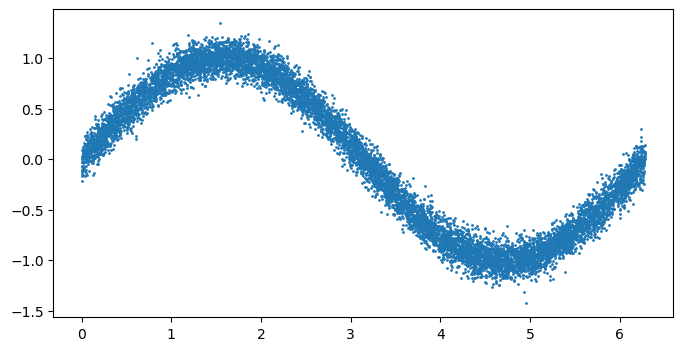

In [7]:
import numpy as np

x=np.random.rand(10000)*2*np.pi
x=x.reshape(-1, 1)
y=np.sin(x)+0.1*np.random.randn(10000).reshape(-1, 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(x[:,0], y[:,0], s=1)

from sklearn.cluster import KMeans
nc=5
kmeans = KMeans(n_clusters=nc, random_state=0).fit(x)


clustered_Reg=[]
x_mean_L=[]
x_std_L=[]
y_mean_L=[]
nx=1
ny=1
kgain_L=[]
for j in range(nc):
    a=np.where(kmeans.labels_==j)[0]
    x_a=x[a]
    y_a=y[a]
    cov_all=np.cov(x_a.T, y_a.T)
    covxx=cov_all[:nx, :nx]
    covyx=cov_all[nx:, :nx]
    convxx_inv=np.linalg.inv(covxx+np.eye(nx)*1e-4)
    kgain=covyx@convxx_inv
    # kalman filter formula
    # kgain = cov_xy * inv(cov_yy + obs_cov)
    # x_up = x_mean + kgain * (y - y_mean)
    kgain_L.append(kgain)
    x_mean=np.mean(x_a)
    x_std=np.std(x_a)
    x_std_L.append(x_std)
    y_mean=np.mean(y_a)
    x_mean_L.append(x_mean)
    y_mean_L.append(y_mean)
x_test=(np.random.rand(1000)*2*np.pi).reshape(-1, 1)
y_mean_L=np.array(y_mean_L)
x_mean_L=np.array(x_mean_L)

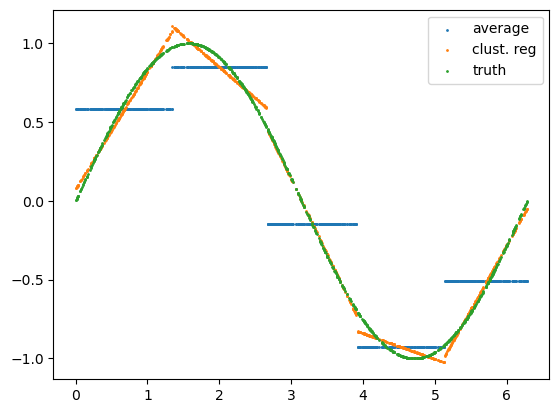

In [8]:
labels_=kmeans.predict(x_test)
y_pred=y_mean_L[labels_]
y_pred_clust_reg=y_pred.copy()
for i in range(nc):
    a=np.where(labels_==i)[0]
    y_pred_clust_reg[a]=y_mean_L[i]+kgain_L[i]@((x_test[a]-x_mean_L[i])).T

plt.scatter(x_test[:,0], y_pred, s=1)
plt.scatter(x_test[:,0], y_pred_clust_reg, s=1)
plt.scatter(x_test[:,0], np.sin(x_test[:,0]), s=1)
plt.legend(['average', 'clust. reg', 'truth'])

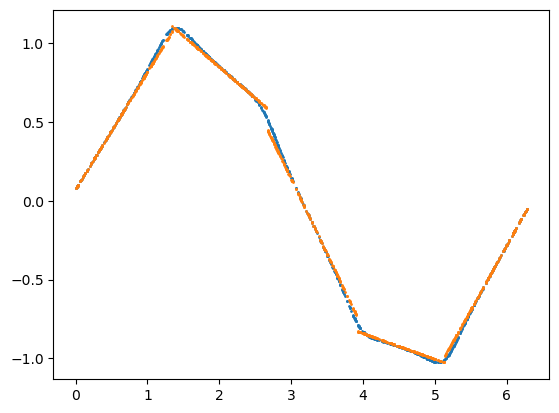

In [9]:
#calculate the probability of points x belong to each cluster manually

def calc_prob(x, x_mean, x_std):
    # calculate the probability of points x belong to each cluster
    # using the Gaussian distribution
    prob = 1/(x_std*np.sqrt(2*np.pi))*np.exp(-(x-x_mean)**2/(2*x_std**2))
    return prob
def calc_prob_all(x, x_mean_L, x_std_L):
    # calculate the probability of points x belong to each cluster
    # using the Gaussian distribution
    prob = np.zeros((len(x), len(x_mean_L)))
    for i in range(len(x_mean_L)):
        prob[:, i] = calc_prob(x, x_mean_L[i], x_std_L[i])
    return prob

y_pred_clust_reg_w=np.zeros((len(x_test), len(x_mean_L)))
total_prob=np.zeros((len(x_test)))
for i in range(nc):
    y_pred_i=y_mean_L[i]+kgain_L[i]@((x_test-x_mean_L[i])).T
    probs=calc_prob(x_test[:,0], x_mean_L[i], x_std_L[i])
    y_pred_clust_reg_w+=probs.reshape(-1, 1)*y_pred_i.T
    total_prob+=probs

y_pred_clust_reg_w=y_pred_clust_reg_w/total_prob.reshape(-1, 1)
plt.scatter(x_test[:,0], y_pred_clust_reg_w[:,0], s=1)
plt.scatter(x_test[:,0], y_pred_clust_reg, s=1)